<div style="display: flex; justify-content: space-between; align-items: center;">
  <img src="BUE.png" style="width: 200px;">
  <img src="Zewail-City.png" style="width: 200px;">
</div>

---

# __Solar Wind Heliospheric 1D Analysis__

In [1]:
# Required libraries
import numpy as np
import pandas as pd
import scipy as sc
from scipy.constants import m_p, k as kB, e, pi
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy.special import gamma

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Math

# **Moment Calculations**


## Physical Meaning of the First Four Moments of a Distribution Function

Given a 1D velocity distribution function $f(v)$, the **n-th moment** is defined as:

$$
M_n = \int (v - \langle v \rangle)^n f(v)\, dv
$$

Here’s what the first four moments represent:

---

### **0th Moment** — Number Density

$$
M_0 = \int f(v)\, dv = n
$$

- **Physical meaning**: Total number of particles per unit volume  
- **Units**: particles/m³  
- **Interpretation**: Area under the curve of $f(v)$

---

### **1st Moment** — Bulk Velocity

$$
\langle v \rangle = \frac{1}{n} \int v f(v)\, dv
$$

- **Physical meaning**: Average (mean) velocity of the particles  
- **Units**: m/s  
- **Interpretation**: Center of mass motion of the plasma

---

### **2nd Moment** — Pressure / Temperature

$$
\langle (v - \langle v \rangle)^2 \rangle = \frac{1}{n} \int (v - \langle v \rangle)^2 f(v)\, dv
$$

- **Physical meaning**: Variance of velocity; related to thermal energy  
- **Units**: (m/s)²  
- **Interpretation**: Spread of the velocity distribution  
- Often used to calculate pressure:

$$
P = m n \langle (v - \langle v \rangle)^2 \rangle
$$

---

### **3rd Moment** — Skewness

$$
\langle (v - \langle v \rangle)^3 \rangle = \frac{1}{n} \int (v - \langle v \rangle)^3 f(v)\, dv
$$

- **Physical meaning**: Asymmetry of the distribution around the mean  
- **Units**: (m/s)³  
- **Interpretation**:  
  - Positive skew → long tail toward high velocities  
  - Negative skew → long tail toward low velocities

---

### **4th Moment** — Kurtosis
The kurtosis measures the **peakedness** and **tail weight** of a probability distribution relative to a normal (Gaussian or Maxwellian) distribution.
$$
\langle (v - \langle v \rangle)^4 \rangle = \frac{1}{n} \int (v - \langle v \rangle)^4 f(v)\, dv
$$

- **Physical meaning**: Peakedness of the distribution  
- **Units**: (m/s)⁴  
- **Interpretation**:  
  - High kurtosis → sharp peak and heavy tails  
  - Low kurtosis → flatter distribution
While **variance** (2nd moment) tells you how wide the distribution is overall, **kurtosis** tells you where the spread is coming from — **the core or the tails**.

## Visualization Example

| **Distribution Type**     | **Description**                                                             |
|---------------------------|------------------------------------------------------------------------------|
| **Gaussian (kurtosis = 3)** | Normal distribution (Maxwellian) — Moderate peak, moderate tails                                               |
| **High kurtosis (>3)**    | Sharp peak, fat (heavy) tails — more extreme velocities
| **Low kurtosis (<3)**     | Flat peak, short (thin) tails  — fewer particles far from the mean|

---

##  Summary

- **Kurtosis** is a statistical tool to identify **non-thermal features** in a plasma.
- When combined with **skewness**, it helps assess:
  - Whether a distribution is **symmetric**
  - How far it **deviates from a Maxwellian (thermal equilibrium)**  
- It is a **dimensionless** quantity when normalized by $\sigma^4$, where $ \sigma$ is the standard deviation.

---

## Summary of Moments in 1D

| Moment         | Mathematical Expression                                                                 | Physical Meaning                           |
|----------------|------------------------------------------------------------------------------------------|--------------------------------------------|
| **0th moment** | $ \displaystyle n = \int f(v)\, dv $                                                  | Number density                             |
| **1st moment** | $\displaystyle \langle v \rangle = \frac{1}{n} \int v\, f(v)\, dv $                  | Bulk (mean) velocity                       |
| **2nd moment** | $ \displaystyle \langle (v - \langle v \rangle)^2 \rangle =  \frac{1}{n} \int (v - \langle v \rangle)^2\, f(v)\, dv $ | Thermal speed or pressure (variance)       |
| **3rd moment** | $ \displaystyle \langle (v - \langle v \rangle)^3 \rangle = \frac{1}{n} \int (v - \langle v \rangle)^3\, f(v)\, dv $ | Skewness (asymmetry of distribution)       |
| **4th moment** | $ \displaystyle \langle (v - \langle v \rangle)^4 \rangle = \frac{1}{n} \int (v - \langle v \rangle)^4\, f(v)\, dv $ | Kurtosis (peakedness or flatness of tail)  |

-The thermal pressure in 1D

$$
P = m\  n\ \displaystyle \langle (v - \langle v \rangle)^2 \rangle = m \int (v - \langle v \rangle)^2 f(v)\, dv
$$

-The thermal pressure in In 3D isotropic:
$$
P =\frac{1}{3}\  n\ \displaystyle \langle (v - \langle v \rangle)^2 \rangle =\frac{1}{3} m \int (v - \langle v \rangle)^2 f(v)\, dv
$$

## Heat Conduction (Heating) Flux in Plasma

To calculate the **heat conduction flux** $\mathbf{q}$ in a plasma or fluid, we distinguish between:

- **Classical (collisional)** heat conduction — typical in dense plasmas or gases  
- **Collisionless (kinetic)** heat flux — typical in space plasmas like the solar wind

---

### Classical (Collisional) Plasmas

In collisional regimes, heat flux is described by **Fourier's Law**:

$$
\mathbf{q} = -\kappa \nabla T
$$

Where:

- $ \mathbf{q}$: heat flux (W/m²)  
- $\kappa$: thermal conductivity (W·m⁻¹·K⁻¹)  
- $\nabla T$: temperature gradient (K/m)

---

###  Example: Fully Ionized Hydrogen (Spitzer Conductivity)

Spitzer (1962) derived the parallel thermal conductivity as:

$$
\kappa_\parallel = 1.84 \times 10^{-5} \frac{T^{5/2}}{\ln \Lambda} \quad \text{W·m}^{-1} \cdot \text{K}^{-1}
$$

Then the **parallel heat flux** becomes:

$$
q_\parallel = -\kappa_\parallel \frac{dT}{dx}
$$

Where:

- $T$: electron temperature (K)  
- $\ln \Lambda$: Coulomb logarithm (typically 10–30)

---

### Collisionless Plasmas (e.g., Solar Wind)

In low-collisionality environments, heat flux comes from the **third moment** of the distribution function:

$$
q = \frac{1}{2} m \int (v - u)^3 f(v)\, dv
$$

Where:

- $f(v)$: particle velocity distribution function  
- $u$: bulk velocity  
- $m$: particle mass  
- $q$: 1D heat flux (W/m²)

## Summary of Heat Conduction Approaches

| **Model Type**   | **Formula**                                                | **When to Use**                                                             |
|------------------|------------------------------------------------------------|-----------------------------------------------------------------------------|
| **Collisional**  |$\mathbf{q} = -\kappa \nabla T$                         | Dense plasmas with strong collisional coupling                             |
| **Collisionless**|$ \mathbf{q} = \frac{1}{2} m \int (v - u)^3 f(v)\, dv $| Collisionless environments like the solar wind or magnetospheric plasmas   |

## Quantities You Can Calculate from a 1D Distribution Function $f(v)$

---

### Basic Fluid Moments (0th–4th)

| Quantity         | Formula                                                                                      | Physical Meaning                           |
|------------------|----------------------------------------------------------------------------------------------|--------------------------------------------|
| **Density**       | $ n = \int f(v)\, dv $                                                                     | Number of particles per unit volume        |
| **Bulk Velocity** | $ u = \langle v \rangle = \frac{1}{n} \int v f(v)\, dv $                                   | Mean flow velocity                         |
| **Pressure**      | $ P = m \int (v - u)^2 f(v)\, dv $                                                         | Thermal pressure                           |
| **Skewness**      | $ \frac{1}{n \sigma^3} \int (v - u)^3 f(v)\, dv $                                          | Distribution asymmetry                     |
| **Kurtosis**      | $ \frac{1}{n \sigma^4} \int (v - u)^4 f(v)\, dv $                                          | Peakedness or tail behavior                |

---

### Energy-related Quantities

| Quantity              | Formula                                                                 | Meaning                                  |
|-----------------------|-------------------------------------------------------------------------|------------------------------------------|
| **Mean kinetic energy** | $ \langle E_k \rangle = \frac{1}{2} m \int v^2 f(v)\, dv $           | Average energy per particle              |
| **Thermal energy**      | $ E_{\text{th}} = \frac{1}{2} m \int (v - u)^2 f(v)\, dv $           | Energy relative to bulk motion           |
| **Energy flux**         | $ q_E = \frac{1}{2} m \int (v - u)^3 f(v)\, dv \  $                    | Heat conduction in 1D (see \mathbf{q} $) |

---

### Entropy and Shape Diagnostics

| Quantity                   | Formula                                                                 | Interpretation                                  |
|----------------------------|-------------------------------------------------------------------------|------------------------------------------------|
| **Entropy (Boltzmann)**     | $ S = -k_B \int f(v) \ln f(v)\, dv $                                  | Degree of disorder (non-Maxwellian-ness)       |
| **Deviation from Maxwellian** | Use statistical divergence (e.g., KL-divergence) from a Maxwellian fit | Quantifies how non-thermal the plasma is       |

---

### Diagnostic Fits & Features

| Quantity                    | How to Compute                                                                 | Use                                            |
|-----------------------------|--------------------------------------------------------------------------------|------------------------------------------------|
| **Maxwellian temperature fit** | Fit $ f(v) $ to a Maxwellian: $ A \exp\left(-\frac{m(v - u)^2}{2k_B T} \right) $ | Extract $ T $ assuming thermal equilibrium |
| **Bi-modal or beam detection** | Look for multi-peak structure in $ f(v) $                                     | Detect reflected, beam, or halo populations   |
| **Tail index (power law)**     | Fit $ f(v) \propto v^{-\alpha} $ in tail region                             | Quantify suprathermal particle strength       |

---

### Convert Entropy to Entropy Per-Particle Value

To convert entropy from total (per unit volume) to **entropy per particle**, use the formula:

$$
S_{\text{per particle}} = \frac{S}{n}
$$

Where:

- $ S$: total entropy per unit volume (in J/K·m³)  
- $n$: number density (in particles/m³)

##  What Can This Tell You in Plasma Physics?

- **Heating**: temperature and heat flux show how plasma is energized  
- **Streaming or beams**: skewness and multi-peak shapes show particle flows  
- **Non-equilibrium**: kurtosis or entropy reveal deviations from Maxwellian  
- **Instabilities**: asymmetry or beams can drive kinetic instabilities (e.g., firehose, bump-on-tail)

##  What is $\sigma$?

$ \sigma$  (the Greek letter sigma) represents the **standard deviation** of the velocity distribution.

It tells you how **spread out** the particle velocities are around the **mean (bulk) velocity**.

It is the **square root of the variance**, which is the **second central moment**.

---

##  Formula

Given a distribution function $ f(v) $, bulk velocity $ u = \langle v \rangle $, and number density $ n $, the standard deviation is:

$$
\sigma = \sqrt{ \frac{1}{n} \int (v - u)^2 f(v)\, dv }
$$

**Where:**

- $f(v) $: particle distribution function in 1D  
- $ v $: velocity variable  
- $ u = \langle v \rangle$: bulk velocity  
- $ n = \int f(v)\, dv $: number density  

---

##  Physical Meaning

- **Low** $\sigma$ → particles are clustered close to the mean velocity (narrow distribution)  
- **High** $ \sigma$ → particles are more spread out (broader distribution = hotter plasma)  

---

In **kinetic theory**, $ \sigma$ is directly related to **temperature** in 1D:

$$
T = \frac{m \sigma^2}{k_B} \quad \Rightarrow \quad \sigma = \sqrt{ \frac{k_B T}{m} }
$$


# 1D Velocity DF:

In [2]:
# === Constants ===
m_p = 1.6726e-27  # kg (proton mass)
kB = 1.3807e-23   # J/K
m_alpha = 4 * m_p  # kg (2 protons + 2 neutrons)
mu0 = 4 * np.pi * 1e-7         # Vacuum permeability [H/m]
nT_to_T = 1e-9                 # nT → T
cm3_to_m3 = 1e6                # cm⁻³ → m⁻³

In [3]:
#The following velocity and distribution function (f) arrays are real data from Helios 2, measured on February 9, 1976, at 00:35:05.
#The two arrays each contain 32 elements, corresponding to the 32 energy channels of E1, the plasma instrument on Helios.

v_arr=np.array([ 178.1586,   191.43102,  205.60291,  221.15424,  237.81458,  254.80132,
  274.95465,  295.68668,  317.56601,  341.42957,  366.89032,  394.73651,
  424.32901,  455.32739,  491.44302,  528.64026,  568.48553,  611.16919,
  657.01642,  707.24902,  760.2403,   815.80646,  880.4483,   947.23059,
 1019.8422,  1096.6,     1178.5919,  1268.673,   1363.6038,  1463.2292,
 1578.946,   1698.548])

f_arr=np.array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
 0.0000000e+00, 2.6393590e-19, 2.9115522e-18, 1.7339317e-17, 3.5426939e-17,
 1.7673032e-17, 1.8904058e-18, 1.9256069e-19, 5.7039686e-19, 4.7156246e-19,
 1.5959650e-19, 3.0702970e-20, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
 0.0000000e+00, 7.3913145e-21])

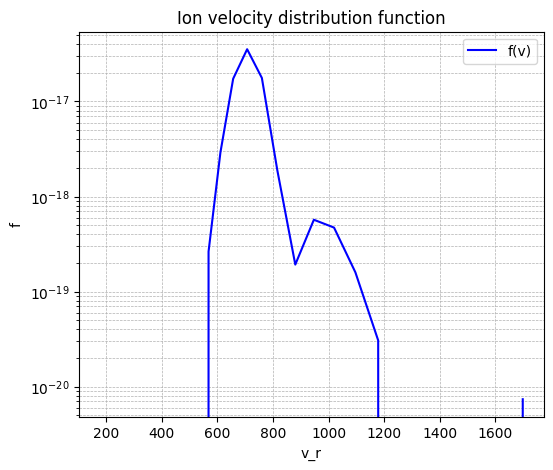

In [4]:
plt.figure(figsize=(6, 5))
plt.plot(v_arr, f_arr, label='f(v)', color='blue')

# Log scale for y-axis
plt.yscale('log')

# Labels and title
plt.xlabel('v_r')
plt.ylabel('f')
plt.title('Ion velocity distribution function')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Show the plot
plt.show()


### local maxima and minima

Local Maxima:
  Index: 19, Velocity: 707.24902, f(v): 3.5426939e-17
  Index: 23, Velocity: 947.23059, f(v): 5.7039686e-19
Local Minima:
  Index: 22, Velocity: 880.4483, f(v): 1.9256069e-19


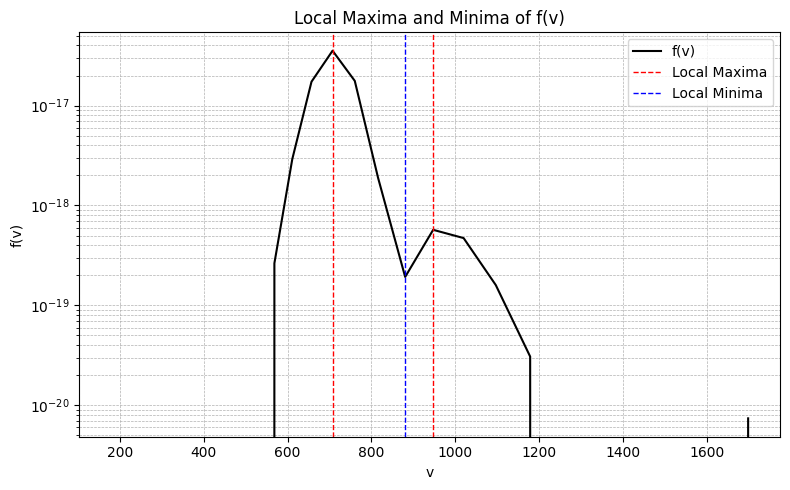

In [5]:
# Find local maxima and minima indices
max_indices = argrelextrema(f_arr, np.greater)[0]
min_indices = argrelextrema(f_arr, np.less)[0]

f_maxima = f_arr[max_indices]
sorted_max_idx = max_indices[np.argsort(f_maxima)[::-1]]  # sort descending

v_proton_max = v_arr[sorted_max_idx[0]]  # highest peak
v_alpha_max  = v_arr[sorted_max_idx[1]]  # second highest peak


# Print local extrema and their indices
print("Local Maxima:")
for i in max_indices:
    print(f"  Index: {i}, Velocity: {v_arr[i]}, f(v): {f_arr[i]}")
print("Local Minima:")
for i in min_indices:
    print(f"  Index: {i}, Velocity: {v_arr[i]}, f(v): {f_arr[i]}")


# Plot the distribution
plt.figure(figsize=(8, 5))
plt.plot(v_arr, f_arr, label='f(v)', color='black')

for i in max_indices:
    plt.axvline(x=v_arr[i], color='red', linestyle='--', linewidth=1, label='Local Maxima' if i == max_indices[0] else "")
for i in min_indices:
    plt.axvline(x=v_arr[i], color='blue', linestyle='--', linewidth=1, label='Local Minima' if i == min_indices[0] else "")

# Optional: log-scale y-axis
plt.yscale('log')

# Plot styling
plt.xlabel('v')
plt.ylabel('f(v)')
plt.title('Local Maxima and Minima of f(v)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Curve Fitting

#### Proton peak:

A Gaussian centered at $ v = v_{\text{proton\_max}} $ with standard deviation $ \sigma $:
$$
f_{\text{Gaussian}}(x, \sigma, n) = n \cdot e^{-\frac{(x - v_{\text{proton\_max}})^2}{2 \sigma^2}}
$$

In [6]:
def gaussian(x, sigma, n):
    return n * np.exp(-(x - v_proton_max)**2 / (2 * sigma**2))

In [7]:
v_start = v_arr[0]
v_cut = v_arr[min_indices[0]]

# Ensure v_start < v_cut
v_min = min(v_start, v_cut)
v_max = max(v_start, v_cut)

# Proper slicing using a boolean mask
mask = (v_arr >= v_min) & (v_arr <= v_max)

v_data = v_arr[mask]
f_data = f_arr[mask]

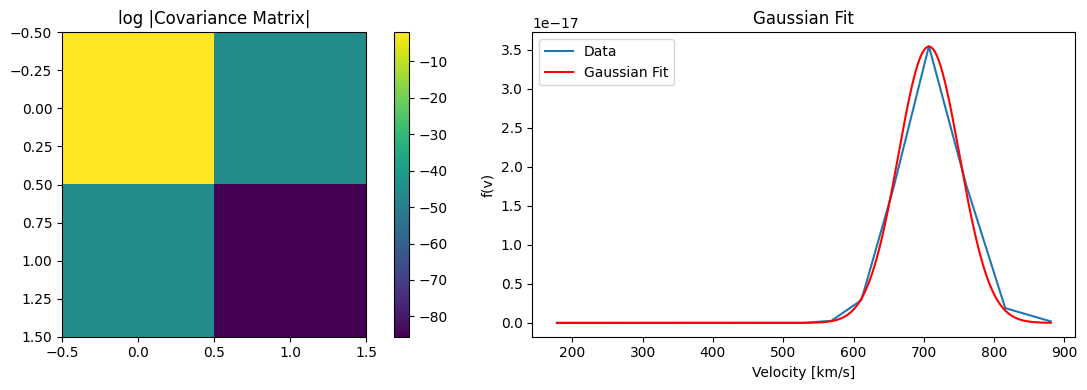

In [8]:
popt, pcov = curve_fit(gaussian, v_data, f_data, p0=[100, np.max(f_data)])

sigma_opt, n_pt = popt

v_model = np.linspace(min(v_data), max(v_data), 1000000)
f_model = gaussian(v_model, sigma_opt, n_pt)

# === Subplots ===
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Covariance matrix
cax = axs[0].imshow(np.log(np.abs(pcov)))
axs[0].set_title("log |Covariance Matrix|")
fig.colorbar(cax, ax=axs[0])

# Plot 2: Data and Gaussian fit
axs[1].plot(v_data, f_data, label='Data')
axs[1].plot(v_model, f_model, color='r', label='Gaussian Fit')
axs[1].set_xlabel('Velocity [km/s]')
axs[1].set_ylabel('f(v)')
axs[1].legend()
axs[1].set_title("Gaussian Fit")

plt.tight_layout()
plt.show()


The **Maxwellian velocity distribution** is defined as:
$$
f_{\text{Maxwellian}}(v, T, n) = 4 \pi n \left(\frac{m_p}{2 \pi k_B T}\right)^{3/2} v^2 e^{-\frac{m_p v^2}{2 k_B T}}
$$

In [9]:
# --- Maxwellian Fit (convert to SI units) ---
v_data_m = v_data
f_data_m = f_data

In [10]:
def maxwellian(v, u, T, n):
    coeff = (m_p / (2 * pi * kB * T))**(3/2)
    exponent = -m_p * (v - u)**2 / (2 * kB * T)
    f = 4 * n * pi * coeff * (v)**2 * np.exp(exponent)
    return f

C:\Users\Hazem\AppData\Local\Temp\ipykernel_45292\3355450252.py:2: RuntimeWarning: invalid value encountered in scalar power
  coeff = (m_p / (2 * pi * kB * T))**(3/2)


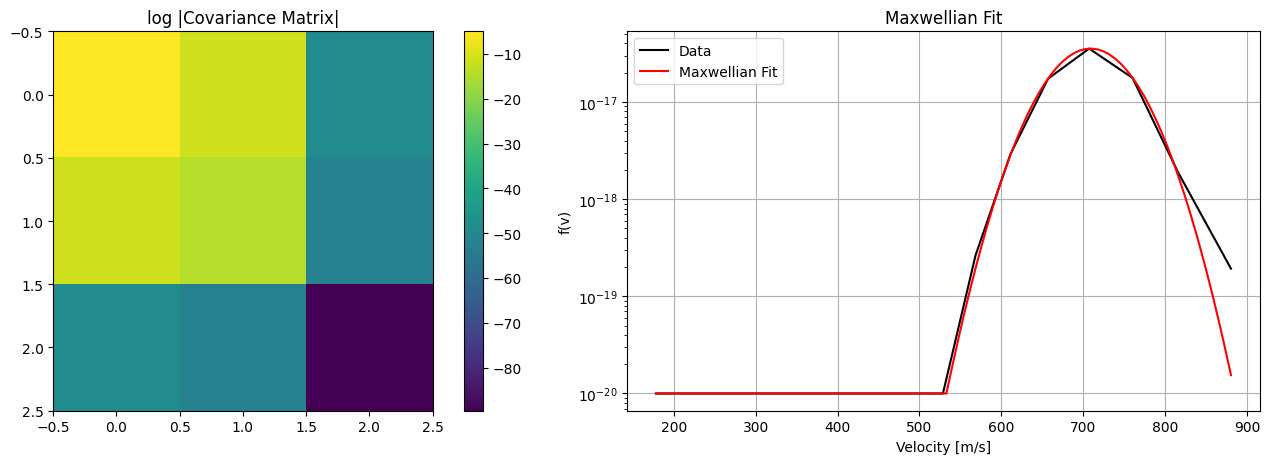

In [11]:
# --- Initial parameter guesses ---
T_guess = 1e4  # Kelvin
n_guess = np.max(f_data_m)
u_guess = 700  # Approx central velocity

# --- Fit the data ---
popt, pcov = curve_fit(
    f=maxwellian,
    xdata=v_data_m,
    ydata=f_data_m,
    p0=[u_guess, T_guess, n_guess * 1e6],
    maxfev=10000,
)

u_opt, T_opt, n_opt = popt

# --- Evaluate model with optimal parameters ---
v_smooth = np.linspace(v_data_m.min(), v_data_m.max(), 100)
f_fit = maxwellian(v_smooth, u_opt, T_opt, n_opt)

# --- Clip values for log plot safety ---
f_data_clipped = np.clip(f_data_m, 1e-20, None)
f_fit_clipped = np.clip(f_fit, 1e-20, None)

# --- Plotting ---
fig, (ax_cov, ax_log) = plt.subplots(1, 2, figsize=(14, 5))

# Covariance matrix
cax = ax_cov.imshow(np.log(np.abs(pcov)))
ax_cov.set_title("log |Covariance Matrix|")
fig.colorbar(cax, ax=ax_cov)

# Logarithmic fit plot
ax_log.plot(v_data_m, f_data_clipped, label='Data', color='black')
ax_log.plot(v_smooth, f_fit_clipped, label='Maxwellian Fit', color='red')
ax_log.set_yscale('log')
ax_log.set_xlabel('Velocity [m/s]')
ax_log.set_ylabel('f(v)')
ax_log.set_title("Maxwellian Fit")
ax_log.grid(True)
ax_log.legend()

# Final layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


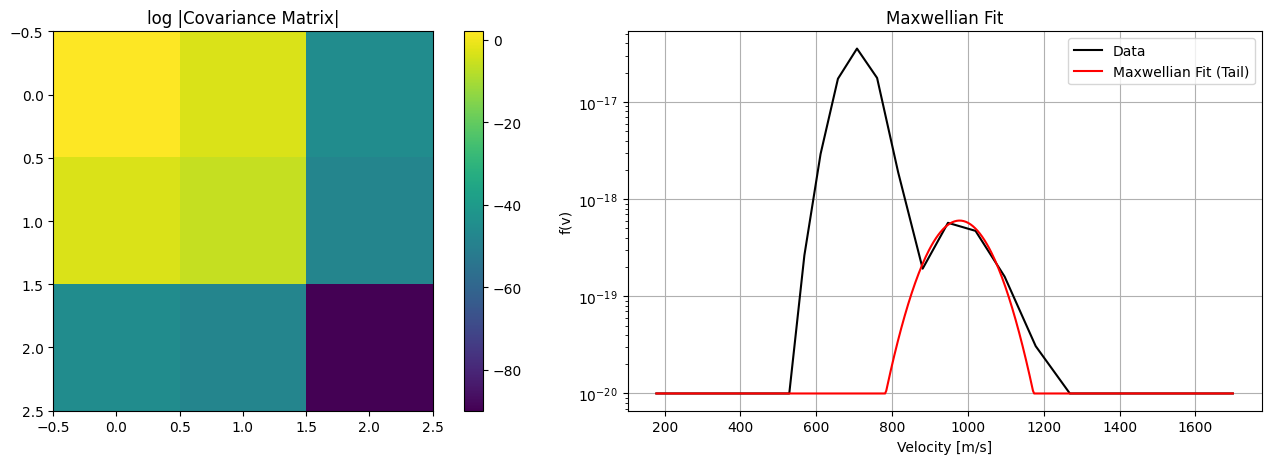

In [12]:
# --- Fit to tail of data ---
popt, pcov = curve_fit(
    maxwellian,
    v_arr[22:],         # fit only the tail
    f_arr[22:],
    p0=[966.4, 6.4e-01, 3.0e-19],
    maxfev=10000,
)

# --- Generate smooth velocity range ---
v_smooth = np.linspace(v_arr.min(), v_arr.max(), 500)
f_fit = maxwellian(v_smooth, *popt)

# --- Clip for log safety ---
f_arr_clipped = np.clip(f_arr, 1e-20, None)
f_fit_clipped = np.clip(f_fit, 1e-20, None)

# --- Plotting ---
fig, (ax_cov, ax_log) = plt.subplots(1, 2, figsize=(14, 5))

# Covariance matrix subplot
cax = ax_cov.imshow(np.log(np.abs(pcov)))
ax_cov.set_title("log |Covariance Matrix|")
fig.colorbar(cax, ax=ax_cov)

# Log-scale fit plot
ax_log.plot(v_arr, f_arr_clipped, label='Data', color='black')
ax_log.plot(v_smooth, f_fit_clipped, label='Maxwellian Fit (Tail)', color='red')
ax_log.set_yscale('log')
ax_log.set_xlabel('Velocity [m/s]')
ax_log.set_ylabel('f(v)')
ax_log.set_title("Maxwellian Fit")
ax_log.grid(True)
ax_log.legend()

# Layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The **bi-Maxwellian velocity distribution function** is defined as:

$$
f(v) = 4\pi v^2 \left[ 
n_1 \left( \frac{m_p}{2\pi k_B T_1} \right)^{3/2} \exp\left( -\frac{m_p (v - u_1)^2}{2k_B T_1} \right)
+
n_2 \left( \frac{m_p}{2\pi k_B T_2} \right)^{3/2} \exp\left( -\frac{m_p (v - u_2)^2}{2k_B T_2} \right)
\right]
$$


In [13]:
def bimaxwellian(v, u1, u2, T1, T2, n1, n2):
    coeff1 = (m_p / (2 * pi * kB * T1))**(3/2)
    coeff2 = (m_p / (2 * pi * kB * T2))**(3/2)
    exp1 = np.exp(-m_p * (v - u1)**2 / (2 * kB * T1))
    exp2 = np.exp(-m_p * (v - u2)**2 / (2 * kB * T2))
    f1 = 4 * pi * n1 * coeff1 * v**2 * exp1
    f2 = 4 * pi * n2 * coeff2 * v**2 * exp2
    return f1 + f2

Bi-Maxwellian fit parameters:
u1=703.6, u2=966.4, T1=2.3e-01, T2=6.4e-01, n1=7.4e-18, n2=3.0e-19


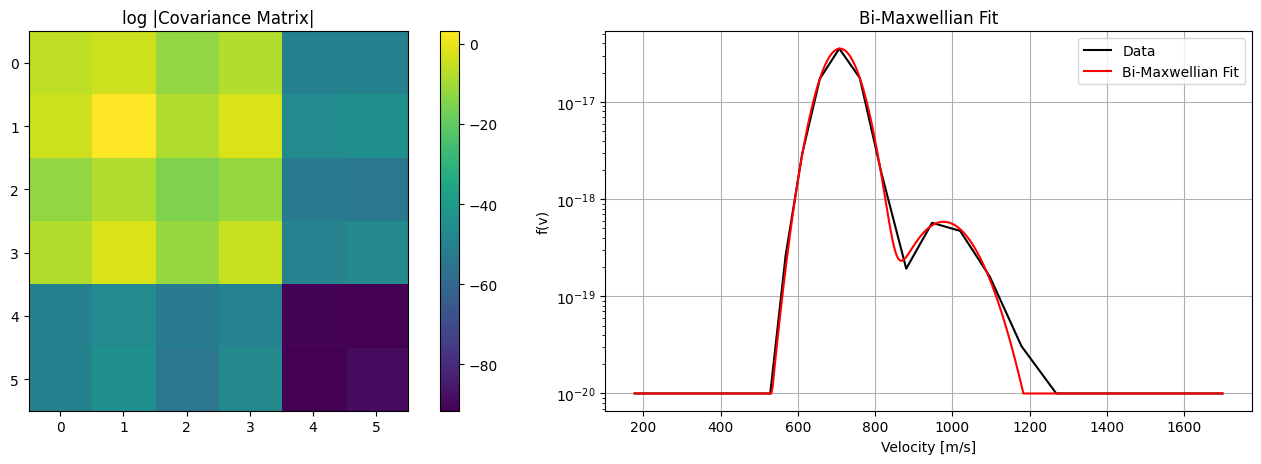

In [14]:
# --- Initial Guess (based on observed distribution) ---
p0 = [
    707, 900,           # u1, u2
    0.23, 0.23,         # T1, T2
    7.44e-18, 7.44e-18  # n1, n2
]

# --- Perform the fit ---
popt, pcov = curve_fit(
    bimaxwellian,
    v_arr,
    f_arr,
    p0=p0,
    maxfev=10000
)

print(f"Bi-Maxwellian fit parameters:\n"
      f"u1={popt[0]:.1f}, u2={popt[1]:.1f}, "
      f"T1={popt[2]:.1e}, T2={popt[3]:.1e}, "
      f"n1={popt[4]:.1e}, n2={popt[5]:.1e}")

# --- Evaluate fit ---
v_smooth = np.linspace(v_arr[0], v_arr[-1], 500)
f_fit = bimaxwellian(v_smooth, *popt)

# --- Clip for log plot safety ---
f_arr_clipped = np.clip(f_arr, 1e-20, None)
f_fit_clipped = np.clip(f_fit, 1e-20, None)

# --- Plotting ---
fig, (ax_cov, ax_log) = plt.subplots(1, 2, figsize=(14, 5))

# Covariance matrix
cax = ax_cov.imshow(np.log(np.abs(pcov)))
ax_cov.set_title("log |Covariance Matrix|")
fig.colorbar(cax, ax=ax_cov)

# Log-scale plot
ax_log.plot(v_arr, f_arr_clipped, label='Data', color='black')
ax_log.plot(v_smooth, f_fit_clipped, label='Bi-Maxwellian Fit', color='red')
ax_log.set_yscale('log')
ax_log.set_xlabel('Velocity [m/s]')
ax_log.set_ylabel('f(v)')
ax_log.set_title('Bi-Maxwellian Fit')
ax_log.grid(True)
ax_log.legend()

# Layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The **isotropic Kappa distribution function** is defined as:
$$
f_{\kappa}(v, T, n) = \frac{n}{\pi^{3/2} \theta^3} \cdot \frac{\Gamma(\kappa + 1)}{\kappa^{3/2} \Gamma(\kappa - 1/2)} \left(1 + \frac{v^2}{\kappa \theta^2} \right)^{-(\kappa + 1)}
$$

In [15]:
def kappa(v, u, T, n, kappa):
    theta = np.sqrt(2 * kB * T / m_p * (kappa - 3/2) / kappa)
    A_kappa = n / (np.pi**1.5 * theta**3) * gamma(kappa + 1) / (kappa**1.5 * gamma(kappa - 0.5))
    return A_kappa * 4 * pi * v**2 * (1 + ((v-u)**2) / (kappa * theta**2))**(-(kappa + 1))

C:\Users\Hazem\AppData\Local\Temp\ipykernel_45292\1492151689.py:2: RuntimeWarning: invalid value encountered in sqrt
  theta = np.sqrt(2 * kB * T / m_p * (kappa - 3/2) / kappa)


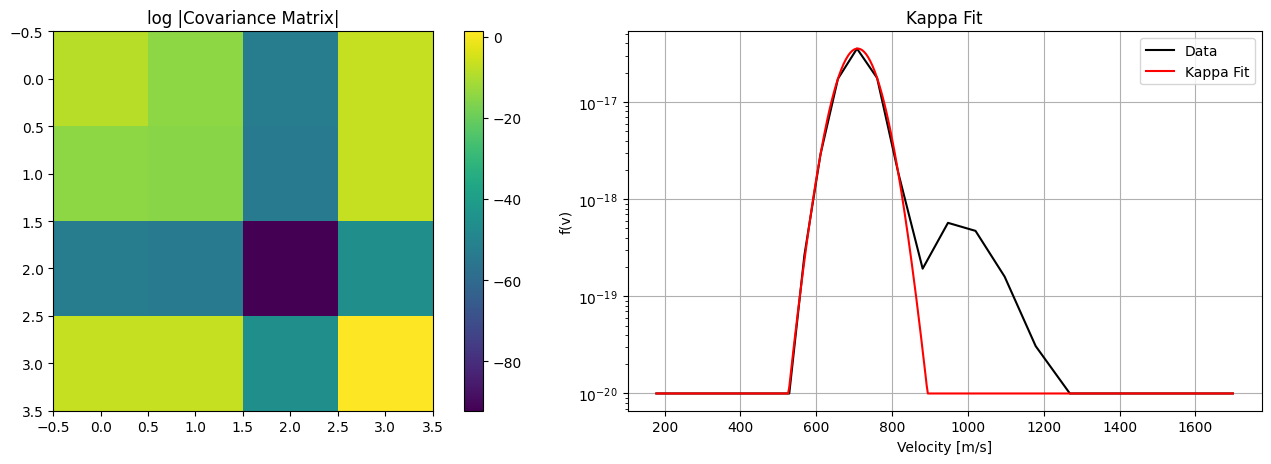

In [16]:
# --- Fit the Kappa distribution to first L points ---
popt, pcov = curve_fit(
    kappa,
    v_arr[:22],
    f_arr[:22],
    p0=[350, 1000, 1e6, 5],  # initial guess: u, T, n, kappa
    # bounds=([0, 1e-10, 1e-10, 1.51], [np.inf, 1e5, 1e12, 100]),
    maxfev=100000,
)

# --- Evaluate the fit ---
v_smooth = np.linspace(v_arr[0], v_arr[-1], 500)
f_fit = kappa(v_smooth, *popt)

# --- Clip for log safety ---
f_arr_clipped = np.clip(f_arr, 1e-20, None)
f_fit_clipped = np.clip(f_fit, 1e-20, None)

# --- Plotting ---
fig, (ax_cov, ax_log) = plt.subplots(1, 2, figsize=(14, 5))

# Covariance matrix
cax = ax_cov.imshow(np.log(np.abs(pcov)))
ax_cov.set_title("log |Covariance Matrix|")
fig.colorbar(cax, ax=ax_cov)

# Log-scale fit plot
ax_log.plot(v_arr, f_arr_clipped, label='Data', color='black')
ax_log.plot(v_smooth, f_fit_clipped, label='Kappa Fit' , color='red')
ax_log.set_yscale('log')
ax_log.set_xlabel('Velocity [m/s]')
ax_log.set_ylabel('f(v)')
ax_log.set_title('Kappa Fit')
ax_log.grid(True)
ax_log.legend()

# Layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


C:\Users\Hazem\AppData\Local\Temp\ipykernel_45292\1492151689.py:2: RuntimeWarning: invalid value encountered in sqrt
  theta = np.sqrt(2 * kB * T / m_p * (kappa - 3/2) / kappa)


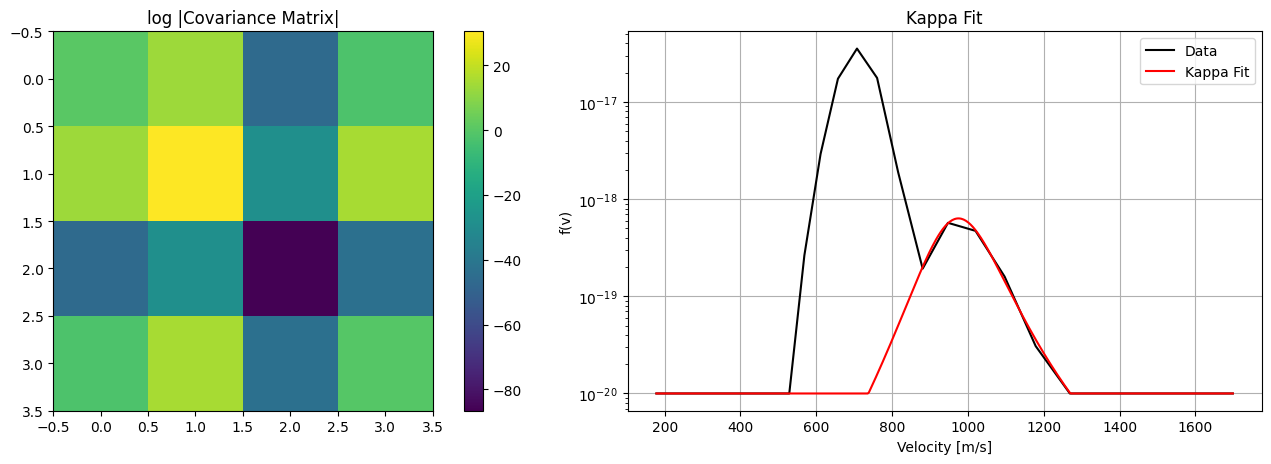

In [17]:
# --- Fit the Kappa distribution to the tail ---
popt, pcov = curve_fit(
    kappa,
    v_arr[22:],
    f_arr[22:],
    p0=[1000, 2e3, 1e6, 10],  # u, T, n, kappa
    maxfev=100000,
)

# --- Evaluate the fit ---
v_smooth = np.linspace(v_arr[0], v_arr[-1], 500)
f_fit = kappa(v_smooth, *popt)

# --- Clip for log scale safety ---
f_arr_clipped = np.clip(f_arr, 1e-20, None)
f_fit_clipped = np.clip(f_fit, 1e-20, None)

# --- Plotting ---
fig, (ax_cov, ax_log) = plt.subplots(1, 2, figsize=(14, 5))

# Covariance matrix
cax = ax_cov.imshow(np.log(np.abs(pcov)))
ax_cov.set_title("log |Covariance Matrix|")
fig.colorbar(cax, ax=ax_cov)

# Log-scale plot
ax_log.plot(v_arr, f_arr_clipped, label='Data', color='black')
ax_log.plot(v_smooth, f_fit_clipped, label='Kappa Fit', color='red')
ax_log.set_yscale('log')
ax_log.set_xlabel('Velocity [m/s]')
ax_log.set_ylabel('f(v)')
ax_log.set_title('Kappa Fit')
ax_log.grid(True)
ax_log.legend()

# Layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


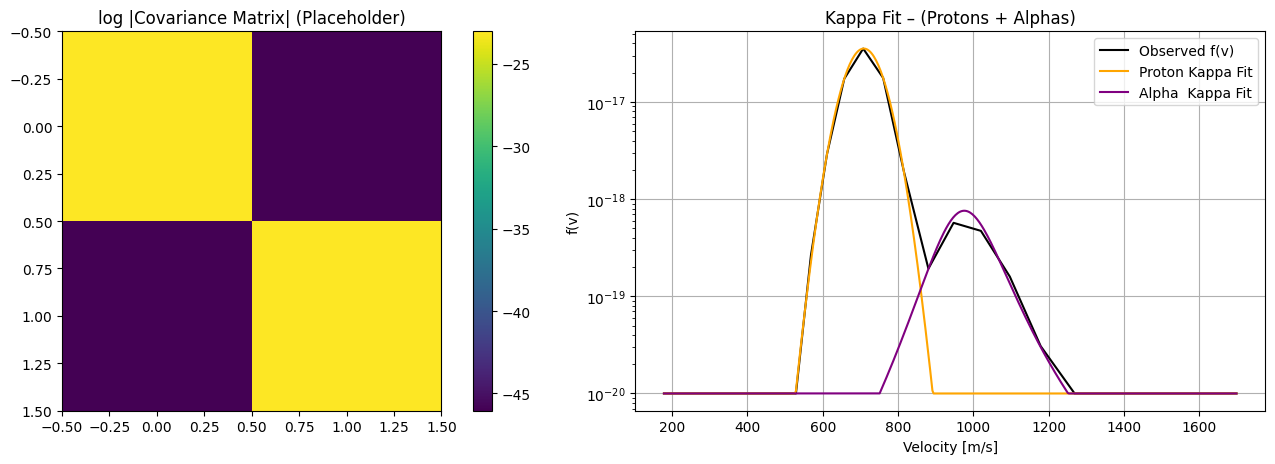

In [18]:
# --- Evaluate both Kappa fits manually ---
v_smooth = np.linspace(v_arr[0], v_arr[-1], 500)

# Proton and Alpha population fits (parameters given)
f_fit_proton = kappa(v_smooth, 7.0355e+02, 2.4026e-01, 7.5775e-18, 5.0868e+01)
f_fit_alpha  = kappa(v_smooth, 9.7020e+02, 2.7027e+03, 4.1412e-19, 1.5003e+00)

# --- Clip for log safety ---
f_arr_clipped           = np.clip(f_arr, 1e-20, None)
f_fit_clipped_proton    = np.clip(f_fit_proton, 1e-20, None)
f_fit_clipped_alpha     = np.clip(f_fit_alpha, 1e-20, None)

# --- Fake covariance matrix (just for placeholder) ---
pcov_fake = np.eye(2) * 1e-10  # Dummy matrix
eps = 1e-20  # To avoid log(0)

# --- Plotting ---
fig, (ax_cov, ax_log) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# Covariance matrix placeholder (safe log)
cax = ax_cov.imshow(np.log(np.abs(pcov_fake) + eps))
ax_cov.set_title("log |Covariance Matrix| (Placeholder)")
fig.colorbar(cax, ax=ax_cov)

# Log-scale fit plot
ax_log.plot(v_arr, f_arr_clipped, label='Observed f(v)', color='black')
ax_log.plot(v_smooth, f_fit_clipped_proton, label='Proton Kappa Fit', color='orange')
ax_log.plot(v_smooth, f_fit_clipped_alpha,  label='Alpha  Kappa Fit', color='purple')
ax_log.set_yscale('log')
ax_log.set_xlabel('Velocity [m/s]')
ax_log.set_ylabel('f(v)')
ax_log.set_title('Kappa Fit – (Protons + Alphas)')
ax_log.grid(True)
ax_log.legend()

# Layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The **bi-Kappa distribution function** describes two distinct particle populations:

$$
f(v) = \sum_{i=1}^{2} \left[ 
\frac{n_i}{\pi^{3/2} \theta_i^3} \cdot \frac{\Gamma(\kappa_i + 1)}{\kappa_i^{3/2} \, \Gamma(\kappa_i - 1/2)} 
\left( 1 + \frac{(v - u_i)^2}{\kappa_i \theta_i^2} \right)^{-(\kappa_i + 1)}
\right]
$$


In [19]:
def bikappa(v, u1, u2, T1, T2, n1, n2, kappa1, kappa2):
    # Core population
    theta1 = np.sqrt(2 * kB * T1 / m_p * (kappa1 - 3/2) / kappa1)
    A1 = n1 / (np.pi**1.5 * theta1**3) * gamma(kappa1 + 1) / (kappa1**1.5 * gamma(kappa1 - 0.5))
    f1 = A1 * (1 + ((v - u1)**2) / (kappa1 * theta1**2))**(-(kappa1 + 1))

    # Halo population
    theta2 = np.sqrt(2 * kB * T2 / m_p * (kappa2 - 3/2) / kappa2)
    A2 = n2 / (np.pi**1.5 * theta2**3) * gamma(kappa2 + 1) / (kappa2**1.5 * gamma(kappa2 - 0.5))
    f2 = A2 * (1 + ((v - u2)**2) / (kappa2 * theta2**2))**(-(kappa2 + 1))

    return f1 + f2

C:\Users\Hazem\AppData\Local\Temp\ipykernel_45292\3067862465.py:9: RuntimeWarning: invalid value encountered in scalar power
  A2 = n2 / (np.pi**1.5 * theta2**3) * gamma(kappa2 + 1) / (kappa2**1.5 * gamma(kappa2 - 0.5))
C:\Users\Hazem\AppData\Local\Temp\ipykernel_45292\3067862465.py:8: RuntimeWarning: invalid value encountered in sqrt
  theta2 = np.sqrt(2 * kB * T2 / m_p * (kappa2 - 3/2) / kappa2)


Bi-Kappa Fit Parameters:
u1     = 7.0897e+02, u2     = 9.7757e+02
T1     = 2.3783e-01, T2     = 3.2042e+03
n1     = 4.6875e-11, n2     = 5.1898e-12
kappa1 = 5.3747e+01, kappa2 = 1.5003e+00


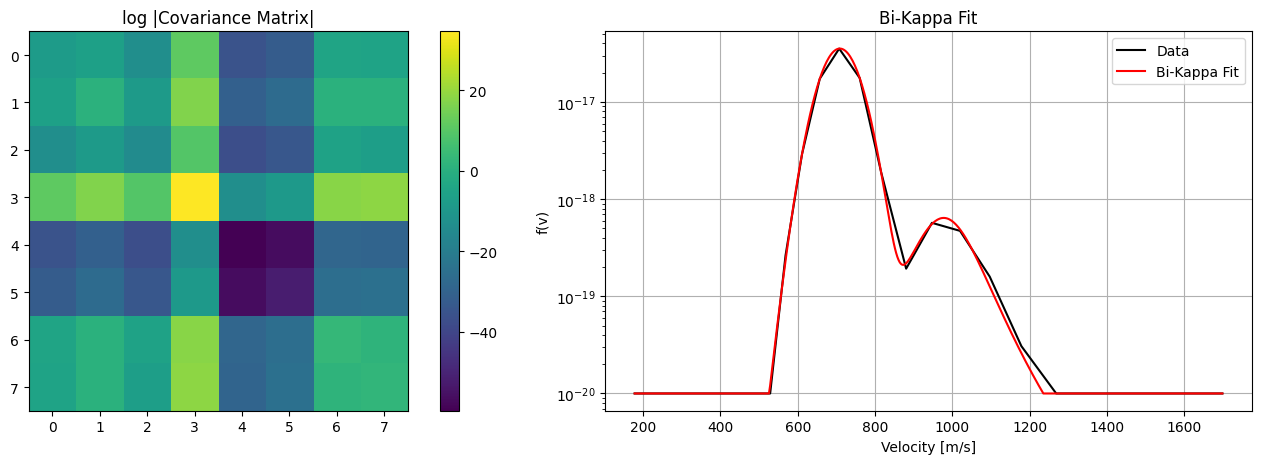

In [20]:
# --- Fit the Bi-Kappa distribution to the full velocity range ---
popt, pcov = curve_fit(
    bikappa,
    v_arr,
    f_arr,
    p0=[
        7.07424756e+02, 9.76605403e+02,     # u1, u2
        2.39334027e-01, 3.01375408e+03,     # T1, T2
        4.46333977e-11, 5.68968931e-12,     # n1, n2
        2.06079871e+01, 1.50033394e+00      # kappa1, kappa2
    ],
    maxfev=1000000
)

print(f"Bi-Kappa Fit Parameters:\n"
      f"u1     = {popt[0]:.4e}, u2     = {popt[1]:.4e}\n"
      f"T1     = {popt[2]:.4e}, T2     = {popt[3]:.4e}\n"
      f"n1     = {popt[4]:.4e}, n2     = {popt[5]:.4e}\n"
      f"kappa1 = {popt[6]:.4e}, kappa2 = {popt[7]:.4e}")

# --- Evaluate the fit ---
v_smooth = np.linspace(v_arr[0], v_arr[-1], 500)
f_fit = bikappa(v_smooth, *popt)

# --- Clip for log safety ---
f_arr_clipped = np.clip(f_arr, 1e-20, None)
f_fit_clipped = np.clip(f_fit, 1e-20, None)

# --- Plotting ---
fig, (ax_cov, ax_log) = plt.subplots(1, 2, figsize=(14, 5))

# Covariance matrix subplot
cax = ax_cov.imshow(np.log(np.abs(pcov)))
ax_cov.set_title("log |Covariance Matrix|")
fig.colorbar(cax, ax=ax_cov)

# Logarithmic plot of fit
ax_log.plot(v_arr, f_arr_clipped, label='Data', color='black')
ax_log.plot(v_smooth, f_fit_clipped, label='Bi-Kappa Fit', color='red')
ax_log.set_yscale('log')
ax_log.set_xlabel('Velocity [m/s]')
ax_log.set_ylabel('f(v)')
ax_log.set_title('Bi-Kappa Fit')
ax_log.grid(True)
ax_log.legend()

# Layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


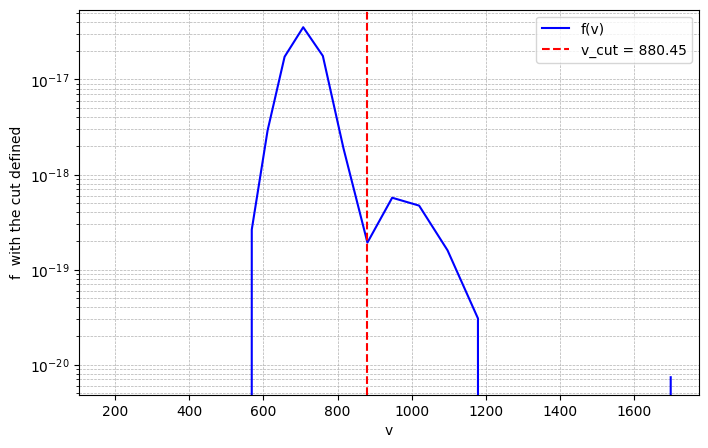

In [21]:
#Now we aim to separate the alpha population from the protons population,
# to do this change the number of the element in the following line and
# plot until you find the perfect cut.

v_cut = v_arr[22]

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(v_arr, f_arr, label='f(v)', color='blue')

# Add vertical line at v_cut
plt.axvline(x=v_cut, color='red', linestyle='--', label=f'v_cut = {v_cut:.2f}')

# Log scale for y-axis
plt.yscale('log')

# Labels and title
plt.xlabel('v')
plt.ylabel('f  with the cut defined')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Show the plot
plt.show()


| Quantity                   | Symbol            | Expression                                           | Units            | Description                        |
| -------------------------- | ----------------- | ---------------------------------------------------- | ---------------- | ---------------------------------- |
| **Velocity**               | $v$               | ———————————————                                                    | m/s              | Particle speed                     |
| **Distribution function**  | $f(v)$            | ———————————————                                                    | m⁻⁶·s³           | Probability density in phase space |
| **Density**                | $n$               | $\int f(v) \, dv$                                    | m⁻³              | 0th moment                         |
| **Bulk velocity**          | $u$               | $\frac{1}{n} \int v f(v) \, dv$                      | m/s              | 1st moment / mean                  |
| **Moment $n$**             | $M_n$             | $\int (v - u)^n f(v) \, dv$ (central for $n \geq 2$) | m⁻³·(m/s)$^{n} $ | Central moments of $f(v)$          |
| **Pressure**               | $p$               | $m \cdot M_2^{\text{central}}$                       | Pa = kg·m⁻¹·s⁻²  | Thermal motion pressure            |
| **Temperature**            | $T$               | $\frac{p}{n k_B}$ or $\frac{p}{n e}$                 | K or eV          | Thermal energy per particle        |
| **Thermal velocity**       | $v_{\text{th}}$   | $\sqrt{2 T_{\text{eV}} e / m}$                       | m/s              | RMS of velocity fluctuation        |
| **Heat flux**              | $q$               | $\frac{1}{2} m \int (v - u)^3 f(v) \, dv$            | W/m² = kg·s⁻³    | 3rd central moment                 |
| **Entropy density**        | $S$               | $-k_B \int f \log f \, dv$                           | J/(K·m³)         | Entropy per unit volume            |
| **Entropy per particle**   | $S_p$             | $\frac{S}{n}$                                        | J/K              | Entropy per particle               |
| **Kinetic energy density** | $E_{\text{kin}}$  | $\frac{1}{2} m \int v^2 f(v) \, dv$                  | J/m³             | Total particle energy              |
| **Thermal energy density** | $E_{\text{th}}$   | $\frac{1}{2} m \int (v - u)^2 f(v) \, dv$            | J/m³             | Energy due to random motion        |
| **Bulk energy density**    | $E_{\text{bulk}}$ | $\frac{1}{2} m n u^2$                                | J/m³             | Energy due to bulk motion          |


### Protons Calc. :

In [22]:
# Calculations for protons 

# Keep only the first x elements + defining const
v_protons = v_arr[:23] #number here is x+1
f_protons = f_arr[:23]*10**30 # converting from cm to km since v is in km # units of f (cm^-6 s^-3) )
v_protons_m = v_protons * 1e3  # convert km/s → m/s
f_protons_m = f_protons * 1e12  # convert cm⁻⁶ → m⁻⁶

#Compute density using trapzal integration
density_p = np.trapz(f_protons_m,v_protons_m)

density_p_in_cm = density_p*10**-15 # 10**-15 is to convert the density to cm^-3

display(Math(r'\text{Density} = %.4e \ \text{cm}^{-3}' % density_p_in_cm))


<IPython.core.display.Math object>

In [23]:
# === 1st Moment: Bulk velocity ===
bulk_velocity_p = np.trapz(v_protons * f_protons, v_protons) / density_p  # [km/s]

# === 2nd Central Moment: Variance & Standard Deviation ===
variance_p = np.trapz((v_protons - bulk_velocity_p)**2 * f_protons, v_protons) / density_p
sigma_p = np.sqrt(variance_p)  # [m/s]

# === 2nd Moment: Pressure ===
pressure_p = m_p * np.trapz((v_protons - bulk_velocity_p)**2 * f_protons, v_protons)  # [Pa]

# === Temperature (K and eV) ===
temperature_p_K = pressure_p / (density_p * kB)
temperature_p_eV = temperature_p_K * kB / 1.602e-19

# === Thermal velocity ===
thermal_velocity_p = sigma_p  # (standard deviation)

# === 3rd Central Moment: Skewness ===
skewness_p = (
    np.trapz((v_protons - bulk_velocity_p)**3 * f_protons, v_protons)
    / (density_p * sigma_p**3)
)

# === 4th Central Moment: Kurtosis ===
kurtosis_p = (
    np.trapz((v_protons - bulk_velocity_p)**4 * f_protons, v_protons)
    / (density_p * sigma_p**4)
)

# === Energy-related Quantities ===

# Mean kinetic energy: ⟨½mv²⟩
mean_kinetic_energy_p = 0.5 * m_p * np.trapz(v_protons**2 * f_protons, v_protons)

# Thermal energy: ⟨½m(v - u)²⟩
thermal_energy_p = 0.5 * m_p * np.trapz((v_protons - bulk_velocity_p)**2 * f_protons, v_protons)

# Energy flux (3rd moment again, unnormalized): q = ½m∫(v - u)³f dv
q_p = 0.5 * m_p * np.trapz((v_protons - bulk_velocity_p)**3 * f_protons, v_protons)

# === Entropy ===
f_protons_m_c = np.array(f_protons_m, dtype=np.float64)
f_protons_m_c = np.nan_to_num(f_protons_m_c)
f_safe = np.where(f_protons_m_c > 0, f_protons_m_c, 1e-30)

entropy_p = -kB * np.trapz(f_safe * np.log(f_safe), v_protons_m)  # J/K·m³
entropy_per_particle_p = entropy_p / density_p                    # J/K

# === Macroscopic Quantities ===
mass_density_p = m_p * density_p                                  # kg/m³
momentum_density_p = mass_density_p * bulk_velocity_p             # kg/(m²·s)

### more Macroscopic Quantities

Dynamic Pressure :
$$
P_{\text{dyn}} = \rho u^2 = m n u^2
$$

Thermal Mach Number :
$$
M = \frac{u}{v_{\text{th}}}
$$

Sound Speed :
$$
c_s = \sqrt{\frac{\gamma k_B T}{m}}
$$
- $ \gamma $: adiabatic index (1 for 1D, 5/3 for 3D monoatomic gas)  


Enthalpy per Unit Mass :
$$
h = \frac{5}{2} \cdot \frac{P}{\rho} = \frac{5}{2} \cdot \frac{k_B T}{m}
$$
- Specific enthalpy assuming ideal gas law (monatomic)


In [24]:
# Dynamic pressure: ρ u²
dynamic_pressure_p = mass_density_p * (bulk_velocity_p * 1e3)**2  # in Pascals

# Thermal Mach number: u / v_th
mach_number_p = (bulk_velocity_p * 1e3) / thermal_velocity_p

# Sound speed (1D monoatomic)
gamma = 1.0
sound_speed_p = np.sqrt(gamma * kB * temperature_p_K / m_p)

# Enthalpy per unit mass
enthalpy_per_mass_p = (5/2) * kB * temperature_p_K / m_p


In [25]:
# Step 5: Print results

display(Math(r'\textit{Proton Calculations:}'))
# === 0th moment ===
display(Math(r'\text{Density} = %.4e \ \text{cm}^{-3}' % density_p_in_cm))

# === 1st moment ===
display(Math(r'\text{Bulk velocity} = %.4e \ \text{km/s}' % bulk_velocity_p))

# === 2nd moment ===
display(Math(r'\text{Standard deviation } (\sigma) = %.4e \ \text{m/s}' % sigma_p))
display(Math(r'\text{Thermal velocity } (v_{th}) = %.4e \ \text{m/s}' % thermal_velocity_p))
display(Math(r'\text{Pressure} = %.4e \ \text{Pa}' % pressure_p))
display(Math(r'\text{Temperature} = %.4e \ \text{K}' % temperature_p_K))
display(Math(r'\text{Temperature} = %.4e \ \text{eV}' % temperature_p_eV))

# === 3rd moment ===
display(Math(r'\text{Skewness} = %.4e' % skewness_p))
display(Math(r'\text{Energy flux} = %.4e \ \text{W/m}^2' % q_p))

# === 4th moment ===
display(Math(r'\text{Kurtosis} = %.4e' % kurtosis_p))

# === Energetics ===
display(Math(r'\text{Mean Kinetic Energy} = %.4e \ \text{J}' % mean_kinetic_energy_p))
display(Math(r'\text{Thermal Energy} = %.4e \ \text{J}' % thermal_energy_p))

# === Entropy ===
display(Math(r'\text{Entropy } (S) = %.4e \ \text{J/K} \cdot \text{m}^3' % entropy_p))
display(Math(r'\text{Entropy per particle} = %.4e \ \text{J/K}' % entropy_per_particle_p))

# === Macroscopic (mass & momentum) ===
display(Math(r'\text{Mass density } (\rho) = %.4e \ \text{kg/m}^3' % mass_density_p))
display(Math(r'\text{Momentum density } (\rho u) = %.4e \ \text{kg/(m}^2 \cdot \text{s)}' % momentum_density_p))

# --- Macroscopic Flow and Thermodynamics ---
display(Math(r'\text{Dynamic pressure } = %.4e \ \text{Pa}' % dynamic_pressure_p))
display(Math(r'\text{Mach number } = %.4f' % mach_number_p))
display(Math(r'\text{Sound speed} = %.4e \ \text{m/s}' % sound_speed_p))
display(Math(r'\text{Enthalpy per unit mass} = %.4e \ \text{J/kg}' % enthalpy_per_mass_p))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Alpha calc. :

In [26]:
# Calculations for alpha 

# Keep only the remaining x elements
v_alpha = v_arr[23:] #number here is x+1
f_alpha = f_arr[23:]*10**30 # converting from cm to km since v is in km # units of f (cm^-6 s^-3) )
v_alpha_m = v_alpha * 1e3  # convert km/s → m/s
f_alpha_m = f_alpha * 1e12  # convert cm⁻⁶ → m⁻⁶

# Compute density using trapzal integration
density_a = np.trapz(f_alpha_m,v_alpha_m)

density_a_in_cm = density_a*10**-15 # 10**-15 is to convert the density to cm^-3

display(Math(r'\text{Density} = %.4e \ \text{cm}^{-3}' % density_a_in_cm))

<IPython.core.display.Math object>

In [27]:
# === 1st Moment: Bulk velocity ===
bulk_velocity_a = np.trapz(v_alpha * f_alpha, v_alpha) / density_a  # [km/s]

# === 2nd Central Moment: Variance & Standard Deviation ===
variance_a = np.trapz((v_alpha - bulk_velocity_a)**2 * f_alpha, v_alpha) / density_a
sigma_a = np.sqrt(variance_a)  # [m/s]

# === 2nd Moment: Pressure ===
pressure_a = m_alpha * np.trapz((v_alpha - bulk_velocity_a)**2 * f_alpha, v_alpha)  # [Pa]

# === Temperature (K and eV) ===
temperature_a_K = pressure_a / (density_a * kB)
temperature_a_eV = temperature_a_K * kB / 1.602e-19

# === Thermal velocity ===
thermal_velocity_a = sigma_a  # (standard deviation)

# === 3rd Central Moment: Skewness ===
skewness_a = (
    np.trapz((v_alpha - bulk_velocity_a)**3 * f_alpha, v_alpha)
    / (density_a * sigma_a**3)
)

# === 4th Central Moment: Kurtosis ===
kurtosis_a = (
    np.trapz((v_alpha - bulk_velocity_a)**4 * f_alpha, v_alpha)
    / (density_a * sigma_a**4)
)

# === Energy-related Quantities ===

# Mean kinetic energy: ⟨½mv²⟩
mean_kinetic_energy_a = 0.5 * m_alpha * np.trapz(v_alpha**2 * f_alpha, v_alpha)

# Thermal energy: ⟨½m(v - u)²⟩
thermal_energy_a = 0.5 * m_alpha * np.trapz((v_alpha - bulk_velocity_a)**2 * f_alpha, v_alpha)

# Energy flux (3rd moment again, unnormalized): q = ½m∫(v - u)³f dv
q_a = 0.5 * m_alpha * np.trapz((v_alpha - bulk_velocity_a)**3 * f_alpha, v_alpha)

# === Entropy ===
f_alpha_m_c = np.array(f_alpha_m, dtype=np.float64)
f_alpha_m_c = np.nan_to_num(f_alpha_m_c)
f_safe = np.where(f_alpha_m_c > 0, f_alpha_m_c, 1e-30)

entropy_a = -kB * np.trapz(f_safe * np.log(f_safe), v_alpha_m)  # J/K·m³
entropy_per_particle_a = entropy_a / density_a                    # J/K

# === Macroscopic Quantities ===
mass_density_a = m_alpha * density_a                                  # kg/m³
momentum_density_a = mass_density_a * bulk_velocity_a             # kg/(m²·s)

# Dynamic pressure: ρ u²
dynamic_pressure_a = mass_density_a * (bulk_velocity_a * 1e3)**2  # in Pascals

# Thermal Mach number: u / v_th
mach_number_a = (bulk_velocity_a * 1e3) / thermal_velocity_a

# Sound speed (1D monoatomic)
gamma = 1.0
sound_speed_a = np.sqrt(gamma * kB * temperature_a_K / m_alpha)

# Enthalpy per unit mass
enthalpy_per_mass_a = (5/2) * kB * temperature_a_K / m_alpha


In [28]:
# Step 5: Print results

display(Math(r'\textit{Alpha Calculations:}'))
# === 0th moment ===
display(Math(r'\text{Density} = %.4e \ \text{cm}^{-3}' % density_a_in_cm))

# === 1st moment ===
display(Math(r'\text{Bulk velocity} = %.4e \ \text{km/s}' % bulk_velocity_a))

# === 2nd moment ===
display(Math(r'\text{Standard deviation } (\sigma) = %.4e \ \text{m/s}' % sigma_a))
display(Math(r'\text{Thermal velocity } (v_{th}) = %.4e \ \text{m/s}' % thermal_velocity_a))
display(Math(r'\text{Pressure} = %.4e \ \text{Pa}' % pressure_a))
display(Math(r'\text{Temperature} = %.2f \ \text{K}' % temperature_a_K))
display(Math(r'\text{Temperature} = %.4e \ \text{eV}' % temperature_a_eV))

# === 3rd moment ===
display(Math(r'\text{Skewness} = %.4e' % skewness_a))
display(Math(r'\text{Energy flux} = %.4e \ \text{W/m}^2' % q_a))

# === 4th moment ===
display(Math(r'\text{Kurtosis} = %.4e' % kurtosis_a))

# === Energetics ===
display(Math(r'\text{Mean Kinetic Energy} = %.4e \ \text{J}' % mean_kinetic_energy_a))
display(Math(r'\text{Thermal Energy} = %.4e \ \text{J}' % thermal_energy_a))

# === Entropy ===
display(Math(r'\text{Entropy } (S) = %.4e \ \text{J/K} \cdot \text{m}^3' % entropy_a))
display(Math(r'\text{Entropy per particle} = %.4e \ \text{J/K}' % entropy_per_particle_a))

# === Macroscopic (mass & momentum) ===
display(Math(r'\text{Mass density } (\rho) = %.4e \ \text{kg/m}^3' % mass_density_a))
display(Math(r'\text{Momentum density } (\rho u) = %.4e \ \text{kg/(m}^2 \cdot \text{s)}' % momentum_density_a))

# --- Macroscopic Flow and Thermodynamics ---
display(Math(r'\text{Dynamic pressure } = %.4e \ \text{Pa}' % dynamic_pressure_a))
display(Math(r'\text{Mach number } = %.4f' % mach_number_a))
display(Math(r'\text{Sound speed} = %.4e \ \text{m/s}' % sound_speed_a))
display(Math(r'\text{Enthalpy per unit mass} = %.4e \ \text{J/kg}' % enthalpy_per_mass_a))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Ratios:

In [29]:
display(Math(r'\textbf{Ratios: Alpha / Proton}'))

# === 0th moment: Density ratio ===
density_ratio = density_a / density_p  # Already same input
display(Math(r'\text{Density ratio} = %.3f' % density_ratio))

# === 1st moment ===
bulk_velocity_ratio = bulk_velocity_a / bulk_velocity_p
display(Math(r'\frac{u_\alpha}{u_p} = %.3f' % bulk_velocity_ratio))

# === 2nd moment ===
sigma_ratio = sigma_a / sigma_p
thermal_velocity_ratio = thermal_velocity_a / thermal_velocity_p
pressure_ratio = pressure_a / pressure_p
temperature_K_ratio = temperature_a_K / temperature_p_K
temperature_eV_ratio = temperature_a_eV / temperature_p_eV

display(Math(r'\frac{\sigma_\alpha}{\sigma_p} = %.3f' % sigma_ratio))
display(Math(r'\frac{v_{\text{th}, \alpha}}{v_{\text{th}, p}} = %.3f' % thermal_velocity_ratio))
display(Math(r'\frac{P_\alpha}{P_p} = %.3f' % pressure_ratio))
display(Math(r'\frac{T_{\alpha}}{T_p} = %.3f' % temperature_K_ratio))
display(Math(r'\frac{T_{\alpha}}{T_p} \text{ (eV)} = %.3f' % temperature_eV_ratio))

# === 3rd moment ===
skewness_ratio = skewness_a / skewness_p if skewness_p != 0 else np.nan
energy_flux_ratio = q_a / q_p if q_p != 0 else np.nan

display(Math(r'\frac{\text{Skewness}_\alpha}{\text{Skewness}_p} = %.3f' % skewness_ratio))
display(Math(r'\frac{q_\alpha}{q_p} = %.3f' % energy_flux_ratio))

# === 4th moment ===
kurtosis_ratio = kurtosis_a / kurtosis_p if kurtosis_p != 0 else np.nan
display(Math(r'\frac{\text{Kurtosis}_\alpha}{\text{Kurtosis}_p} = %.3f' % kurtosis_ratio))

# === Energetics ===
mean_ke_ratio = mean_kinetic_energy_a / mean_kinetic_energy_p
thermal_energy_ratio = thermal_energy_a / thermal_energy_p
display(Math(r'\frac{\langle E_k \rangle_\alpha}{\langle E_k \rangle_p} = %.3f' % mean_ke_ratio))
display(Math(r'\frac{E_{\text{th}, \alpha}}{E_{\text{th}, p}} = %.3f' % thermal_energy_ratio))

# === Entropy ===
entropy_ratio = entropy_a / entropy_p
entropy_pp_ratio = entropy_per_particle_a / entropy_per_particle_p
display(Math(r'\frac{S_\alpha}{S_p} = %.3f' % entropy_ratio))
display(Math(r'\left( \dfrac{S_{\alpha} / n_{\alpha}}{S_{p} / n_{p}} \right) = %.3f' % entropy_pp_ratio))

# === Mass & Momentum ===
mass_density_ratio = mass_density_a / mass_density_p
momentum_density_ratio = momentum_density_a / momentum_density_p
display(Math(r'\frac{\rho_\alpha}{\rho_p} = %.3f' % mass_density_ratio))
display(Math(r'\frac{\rho u_\alpha}{\rho u_p} = %.3f' % momentum_density_ratio))

# === Thermodynamic Flow Quantities ===
dynamic_pressure_ratio = dynamic_pressure_a / dynamic_pressure_p
mach_number_ratio = mach_number_a / mach_number_p
sound_speed_ratio = sound_speed_a / sound_speed_p
enthalpy_ratio = enthalpy_per_mass_a / enthalpy_per_mass_p

display(Math(r'\frac{P_{\text{dyn}, \alpha}}{P_{\text{dyn}, p}} = %.3f' % dynamic_pressure_ratio))
display(Math(r'\frac{M_\alpha}{M_p} = %.3f' % mach_number_ratio))
display(Math(r'\frac{c_{s, \alpha}}{c_{s, p}} = %.3f' % sound_speed_ratio))
display(Math(r'\frac{h_\alpha}{h_p} = %.3f' % enthalpy_ratio))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

---